In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm 
rcParams['figure.figsize'] = 10, 15

### Plot Functions

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

In [3]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

In [4]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

### Random Rotation and Translation

In [5]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)
R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Mean Centering

In [6]:
def mean_center(S, exclude_indices=[]):
    reduced_data = np.delete(S, exclude_indices, axis=1)
    center = np.array(reduced_data.mean(axis=1)).T
    return center, S - center.reshape(3,1)

### Cross Covariance Matrix

In [7]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

### Kd tree correspondences

In [8]:
from sklearn.neighbors import KDTree

def kd_tree_correspondences(point_set_p, point_set_q):
    tree = KDTree(point_set_q.T)
    dist, ind = tree.query(point_set_p.T)
    correspondences = [(i, ind[i][0]) for i in range(point_set_p.T.shape[0])]
    return correspondences

### ICP SVD

In [9]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = mean_center(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in tqdm( range(iterations), desc ="Iteration"):
        center_of_P, P_centered = mean_center(P_copy, exclude_indices=exclude_indices)
        correspondences = kd_tree_correspondences(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)
        t = center_of_Q - R.dot(center_of_P)
        P_copy = R.dot(P_copy) + t.reshape(3, 1)
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values


### Random Point set generation P, Q

### 100 points

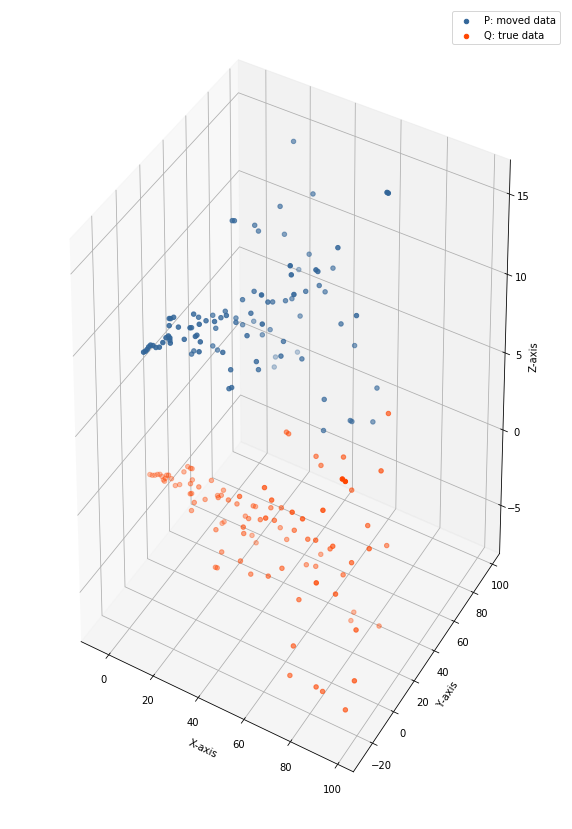

In [10]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Cetering

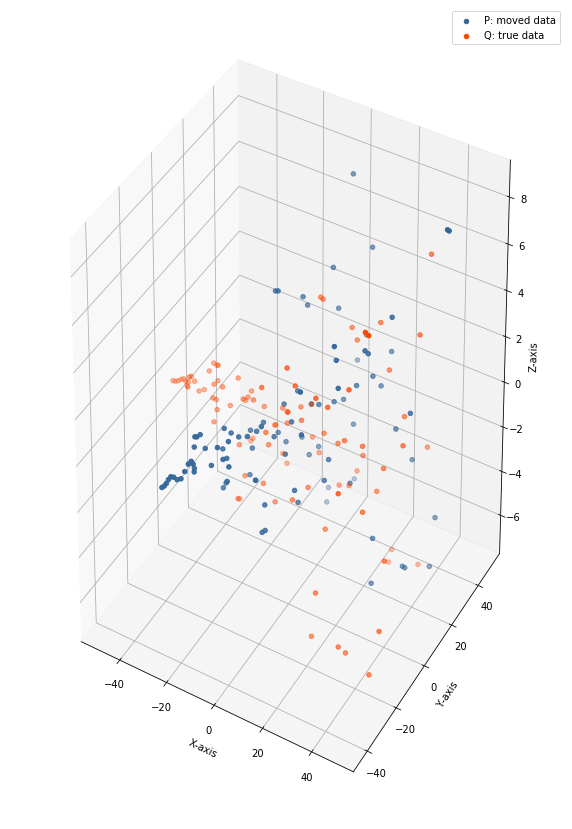

In [11]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

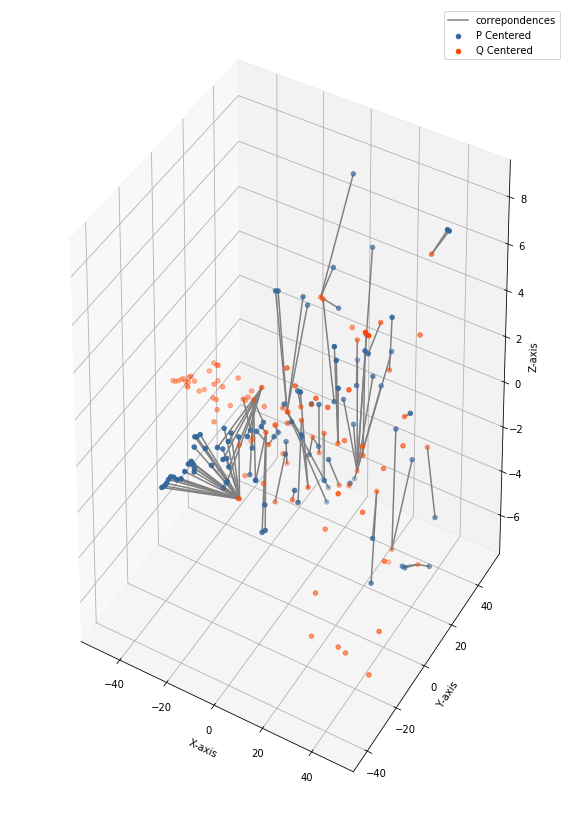

In [12]:
correspondences = kd_tree_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 20/20 [00:00<00:00, 399.99it/s]


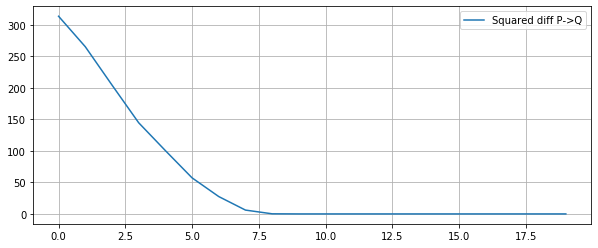

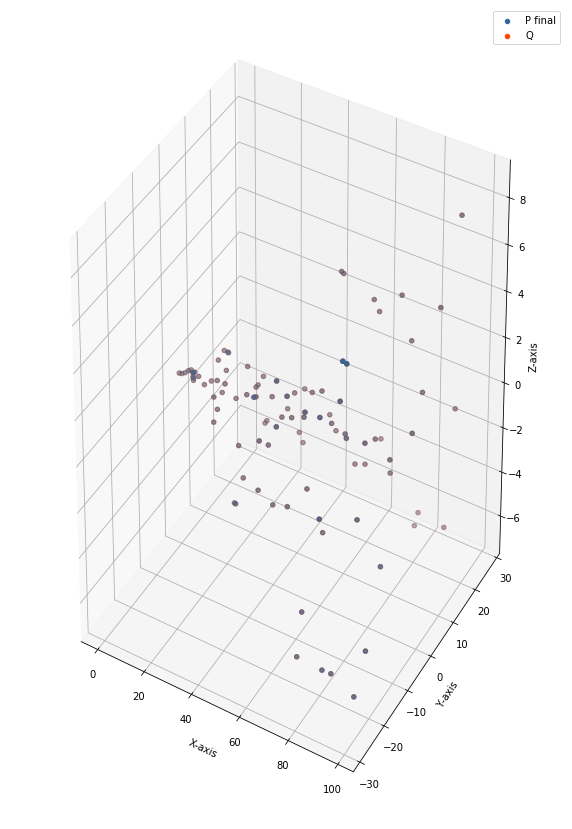

[313.7939925323692, 265.46638258924617, 204.64744550484698, 144.74708339445743, 100.54446851048513, 57.26044777518456, 27.5490240016889, 6.082901398818045, 0.17413633009819549, 6.875160475830917e-13, 7.730347400389601e-13, 8.428149238426106e-13, 8.9199311531104e-13, 1.1189302520661222e-12, 1.2197547493489505e-12, 1.3078882839841902e-12, 1.350187966945897e-12, 1.3129340330531243e-12, 1.3312851261646338e-12, 1.3173855505505161e-12]


In [13]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=20)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

### 10000 points

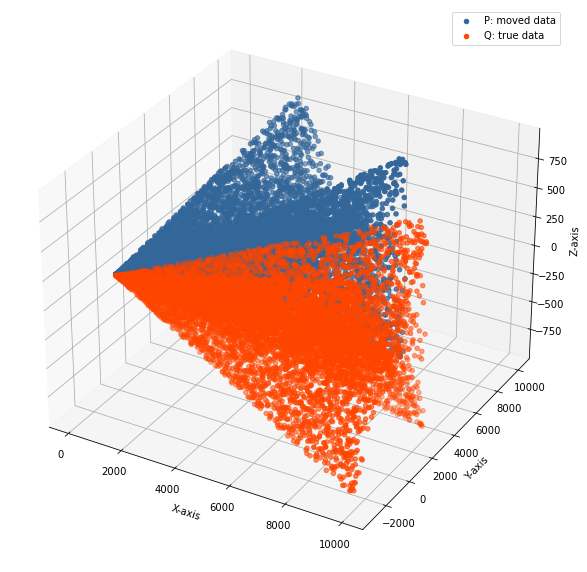

In [23]:
num_points = 10000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

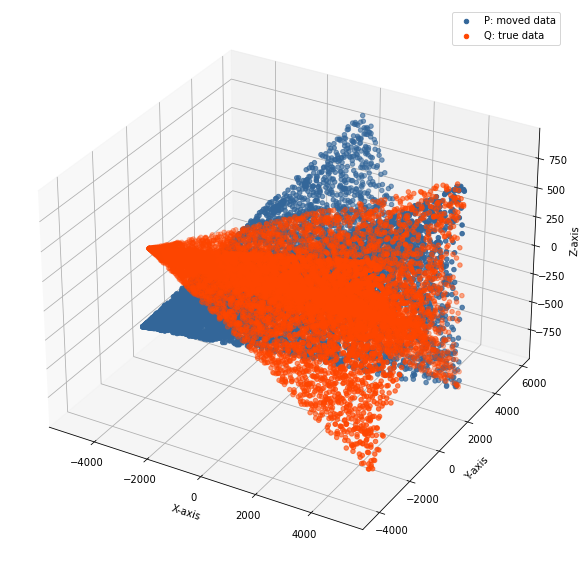

In [24]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

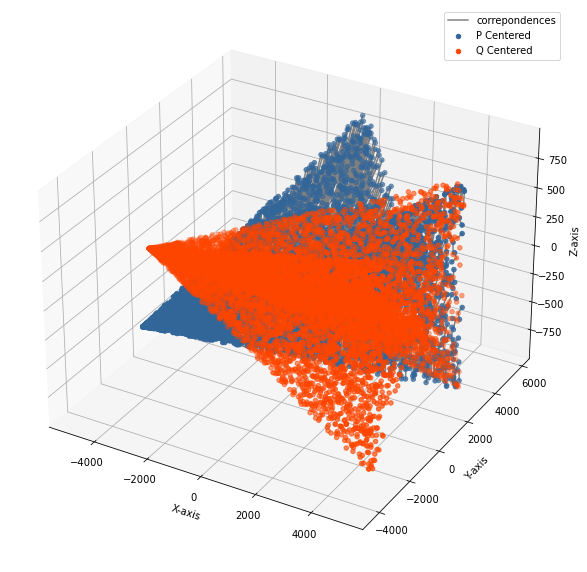

In [25]:
correspondences = kd_tree_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


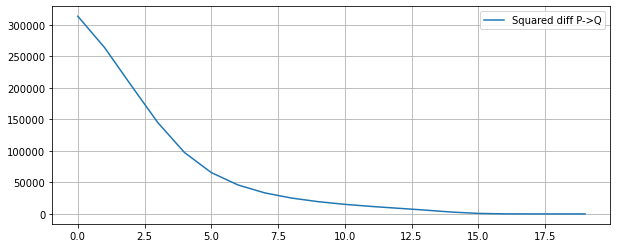

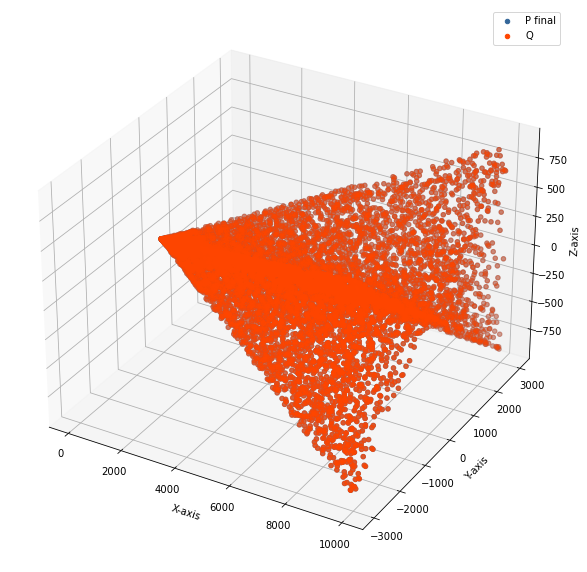

[313576.46567838534, 263996.2717764744, 203729.02901643456, 144676.47962961718, 97238.60741452964, 65561.80923853493, 45914.7152768885, 33387.554982338144, 25182.635102569464, 19437.769851553432, 15160.085415823227, 11854.573001313622, 8965.142438485864, 6085.123783094362, 2949.3498249870186, 820.6850367926738, 56.61343277053542, 4.2726178523740236e-10, 3.4311802708323353e-10, 3.351416415662632e-10]


In [27]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=20)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

### 100000 points

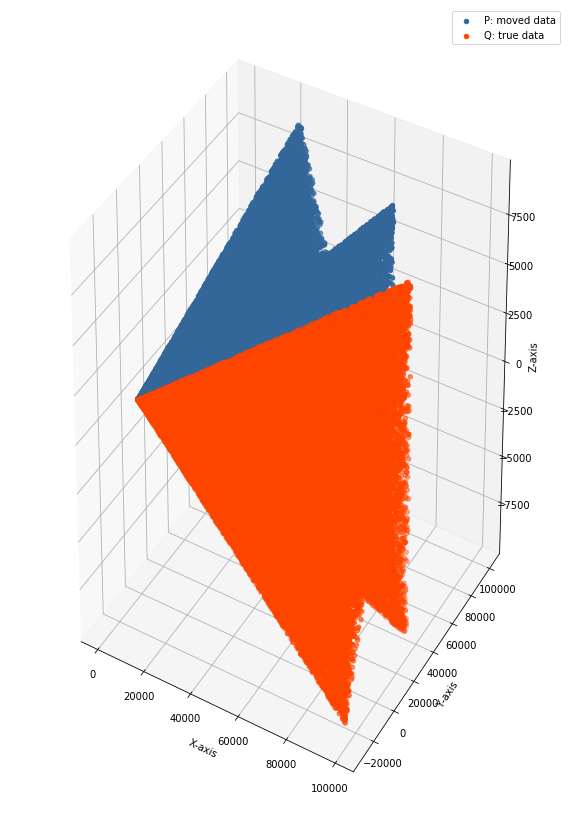

In [14]:
num_points = 100000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

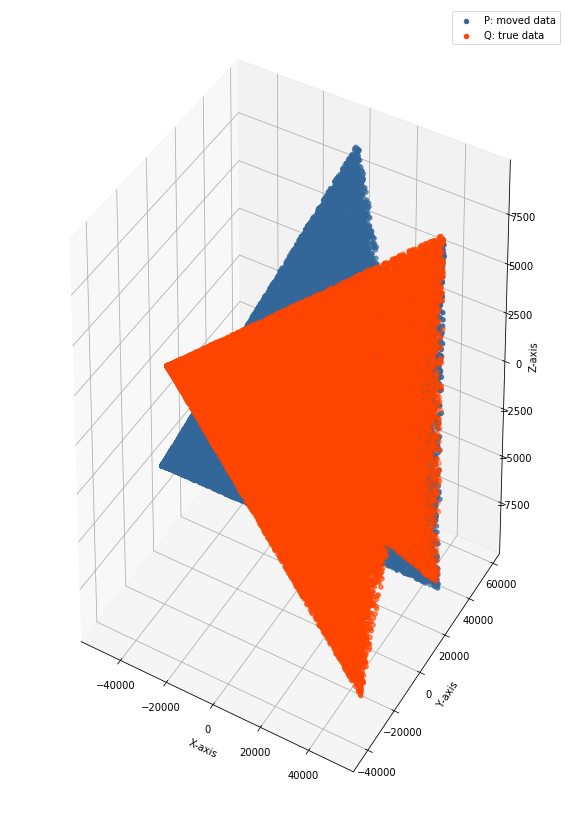

In [15]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### ICP Ran for 10000

Iteration: 100%|██████████| 30/30 [03:08<00:00,  6.28s/it]


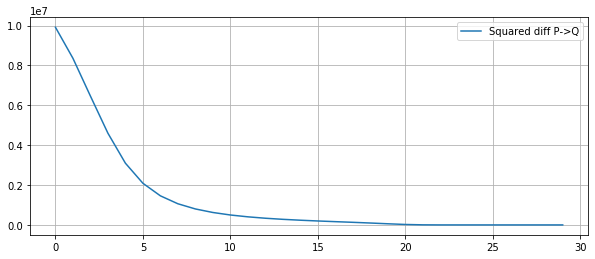

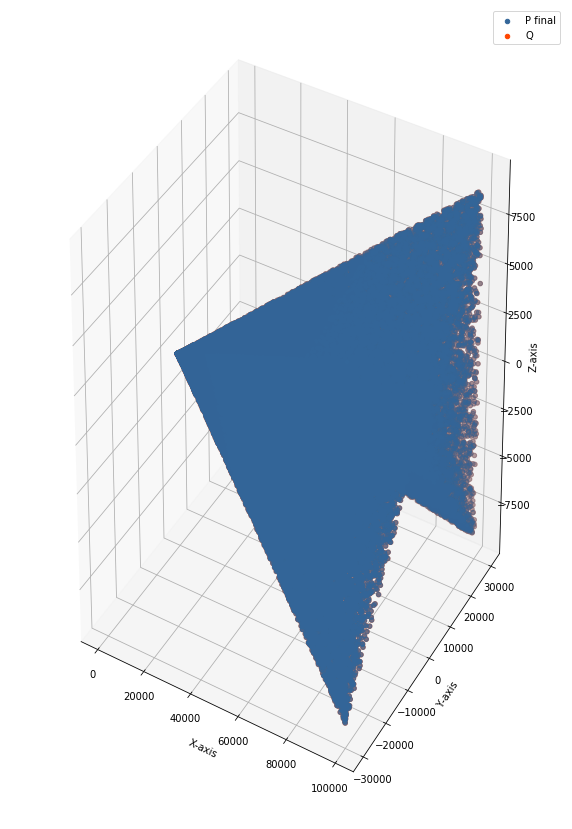

[9916293.095370144, 8359107.194963822, 6463447.1494758045, 4600333.700373222, 3096316.7658320568, 2089665.2716810163, 1459002.280135499, 1061014.324002698, 800882.4180360155, 623718.3913522694, 497899.55952076765, 405711.8428277843, 335372.54733770643, 280437.3046655145, 235922.46234681102, 197670.04144842786, 163550.03742219892, 130499.83730899029, 95132.16261289551, 56980.27562312979, 22353.23021362631, 4052.3330992775805, 86.95251565559263, 4.6786366477352376e-08, 4.7643506693385705e-08, 4.4421759587077594e-08, 4.0200727451873336e-08, 3.78755493572982e-08, 3.619625000623691e-08, 3.656732444088093e-08]


In [17]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=30)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=20)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)